# SINDy Markov Chain Model Analysis

This notebook demonstrates the use of the improved SINDy Markov Chain Model for predicting success probabilities in the Sparse Identification of Nonlinear Dynamics (SINDy) algorithm with Sequential Thresholded Least Squares (STLSQ).

In [8]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import os
import time
from itertools import combinations
from scipy import stats
import sys

module_path = os.path.abspath(os.path.join(os.getcwd(), '..'))
if module_path not in sys.path:
    sys.path.append(module_path)

# Set up plotting
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_context("notebook", font_scale=1.2)

# Create output directories if they don't exist
os.makedirs('logs', exist_ok=True)
os.makedirs('results', exist_ok=True)
os.makedirs('figures', exist_ok=True)

## Import Custom Modules

First, we import the custom modules for the SINDy Markov Chain Model.

In [9]:
# Import custom modules
from models.sindy_markov_model import SINDyMarkovModel
from models.logger_utils import setup_logging, get_logger, log_to_markdown
from models.state_utils import normalize_state, generate_valid_states
from models.simulation_utils import simulate_stlsq, simulate_stlsq_adaptive
from models.library_utils import compute_discriminability, analyze_library_correlations, plot_library_correlations
from models.sindy_markov_analysis import SINDyMarkovAnalysis
from models.logger_utils import suppress_common_warnings
suppress_common_warnings()

## Part 1: Simple Three-Term Example

We'll start with a simple example using three library terms, with only the first term being active in the true model.

In [10]:
# Set up logging
log_file = 'logs/notebook_simple_test.log'
logger = setup_logging(log_file)
logger.info("Starting simple test in notebook")

# Define library functions
def f1(x): return x           # Term 1: x
def f2(x): return np.sin(x)   # Term 2: sin(x)
def f3(x): return np.tanh(x)  # Term 3: tanh(x)

library_functions = [f1, f2, f3]
function_names = ['x', 'sin(x)', 'tanh(x)']

# Define true model: only the first term is present
true_coefs = np.array([1.0, 0.0, 0.0])

# Create model
sigma = 0.1  # Noise level
threshold = 0.05  # STLSQ threshold
model = SINDyMarkovModel(library_functions, true_coefs, sigma, threshold, log_file)

INFO - Starting simple test in notebook
INFO - Initializing SINDy Markov Model
INFO - True term indices: [0]


In [11]:
# Generate sample points
x_range = 1.0
n_samples = 200
x_data = np.random.uniform(-x_range, x_range, n_samples)

# Compute Gram matrix
model.compute_gram_matrix(x_data)

# Analyze library correlations
corr_df, term_values = analyze_library_correlations(x_data, library_functions, function_names)
print("Correlation matrix:")
print(corr_df)

INFO - Computing Gram matrix with 200 sample points
INFO - Log determinant of Gram matrix: -4.7048


Correlation matrix:
                x    sin(x)   tanh(x)
x        1.000000  0.999035  0.997689
sin(x)   0.999035  1.000000  0.999703
tanh(x)  0.997689  0.999703  1.000000


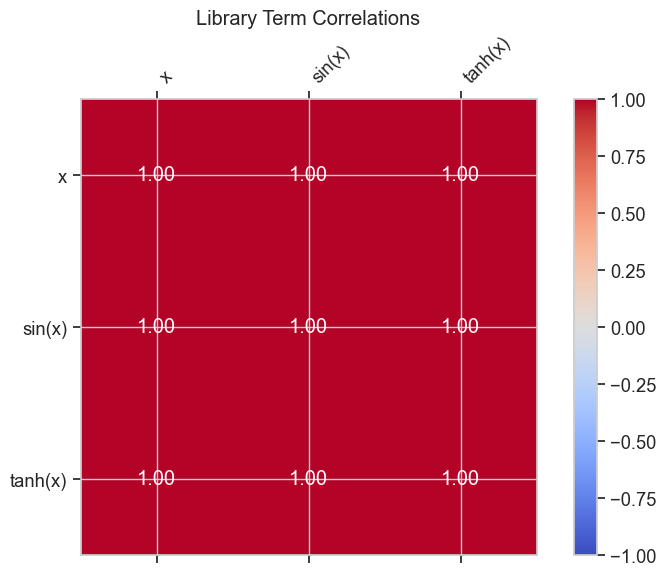

In [12]:
# Plot library correlations
corr_plot = plot_library_correlations(corr_df, figsize=(8, 6))
plt.title('Library Term Correlations')
plt.tight_layout()

In [13]:
# Calculate discriminability
discriminability = compute_discriminability(term_values, sigma)
D_df = pd.DataFrame(discriminability, index=function_names, columns=function_names)
print("Discriminability matrix:")
print(D_df)

Discriminability matrix:
                  x     sin(x)     tanh(x)
x          0.000000  82.406794  209.750613
sin(x)    82.406794   0.000000   29.475861
tanh(x)  209.750613  29.475861    0.000000


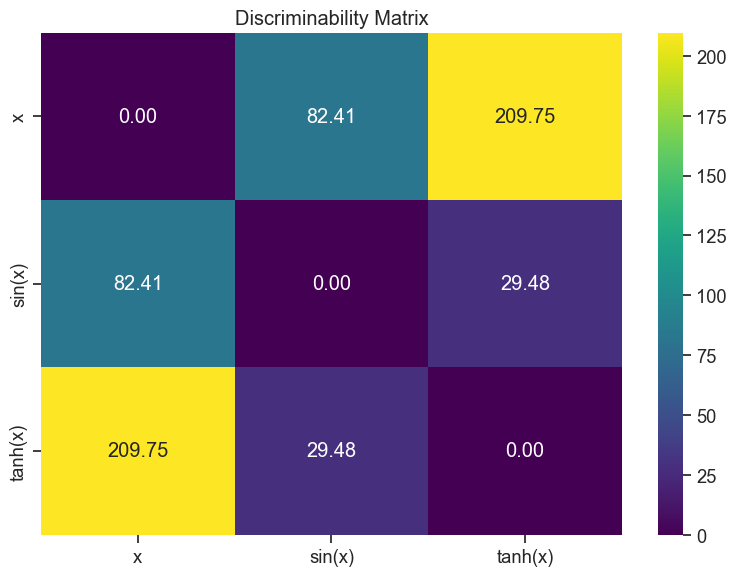

In [14]:
# Plot discriminability matrix
plt.figure(figsize=(8, 6))
sns.heatmap(D_df, annot=True, fmt='.2f', cmap='viridis')
plt.title('Discriminability Matrix')
plt.tight_layout()

In [15]:
# Calculate theoretical success probability
start_time = time.time()
theoretical_prob = model.calculate_success_probability()
theo_time = time.time() - start_time
print(f"Theoretical success probability: {theoretical_prob:.6f} (calculated in {theo_time:.2f} seconds)")

# Calculate empirical success probability
start_time = time.time()
empirical_prob = simulate_stlsq(model, x_data, n_trials=100)
emp_time = time.time() - start_time
print(f"Empirical success probability: {empirical_prob:.6f} (calculated in {emp_time:.2f} seconds)")

# Calculate discrepancy
discrepancy = abs(theoretical_prob - empirical_prob)
print(f"Discrepancy: {discrepancy:.6f}")

INFO - BEGINNING SUCCESS PROBABILITY CALCULATION
INFO - All indices = {0, 1, 2}
INFO - True indices = {0}
INFO - Target state (true model) = {0}
INFO - Generated 4 valid states
INFO - TRUE MODEL STATE TRANSITIONS
INFO - Transitions from {0}:
    -> [STOP]: 1.000000
INFO - TRUE MODEL STATE STOPPING PROBABILITY: 1.000000

ERROR - Error calculating transition probability: unhashable type: 'numpy.ndarray'
ERROR - Error calculating transition probability: unhashable type: 'numpy.ndarray'
ERROR - Error calculating transition probability: unhashable type: 'numpy.ndarray'
ERROR - Error calculating transition probability: unhashable type: 'numpy.ndarray'
ERROR - Error calculating transition probability: unhashable type: 'numpy.ndarray'
INFO - SUCCESS PROBABILITY CALCULATION
INFO - Method 1 - Direct Calculation:
INFO -   Probability of reaching true state:    0.000000
INFO -   Probability of stopping at true state: 1.000000
INFO -   Success probability = 0.000000 × 1.000000 = 0.000000
INFO - END

Theoretical success probability: 0.000000 (calculated in 0.02 seconds)
Empirical success probability: 0.000000 (calculated in 0.02 seconds)
Discrepancy: 0.000000


## Part 2: Comprehensive Analysis

Now we'll perform a more comprehensive analysis using the `SINDyMarkovAnalysis` class.

In [16]:
# Define a more complex library
def f1(x): return x           # Term 1: x
def f2(x): return x**2        # Term 2: x^2
def f3(x): return np.sin(x)   # Term 3: sin(x)
def f4(x): return np.cos(x)   # Term 4: cos(x)

library_functions = [f1, f2, f3, f4]
function_names = ['x', 'x^2', 'sin(x)', 'cos(x)']

# Define true model: first and second terms are active
true_coefs = np.array([1.0, 0.5, 0.0, 0.0])

# Create analysis object
sigma = 0.1  # Noise level
threshold = 0.05  # STLSQ threshold
log_file = 'logs/notebook_comprehensive.log'

analysis = SINDyMarkovAnalysis(library_functions, true_coefs, sigma, threshold, log_file)

INFO - Initializing SINDy Markov Chain Analysis
INFO - Initializing SINDy Markov Model
INFO - True term indices: [0 1]


INFO - Preparing data with range 1.0 and 200 samples
INFO - Computing Gram matrix with 200 sample points
INFO - Log determinant of Gram matrix: 10.4094
INFO - Discriminability between true and false terms:
INFO -   D(0,2) = 87.2074
INFO -   D(0,3) = 20583.3946
INFO -   D(1,2) = 10096.8796
INFO -   D(1,3) = 8499.3642
INFO - High correlation detected: terms 0 and 2: 0.9990
INFO - High correlation detected: terms 1 and 3: -0.9998


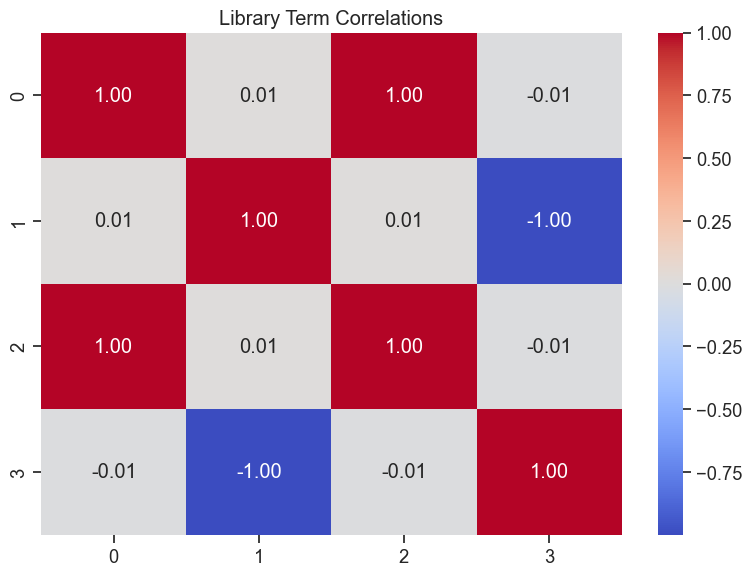

In [17]:
# Prepare data
x_range = 1.0
n_samples = 200
x_data = analysis.prepare_data(x_range, n_samples)

# Display correlations between terms
plt.figure(figsize=(8, 6))
sns.heatmap(analysis.correlations, annot=True, fmt='.2f', cmap='coolwarm')
plt.title('Library Term Correlations')
plt.tight_layout()

In [18]:
# Analyze success probability
success_analysis = analysis.analyze_success_probability(x_data, n_trials=50)

print(f"Success Probability Analysis:")
print(f"  Theoretical: {success_analysis['theoretical']:.6f}")
print(f"  Empirical: {success_analysis['empirical']:.6f}")
print(f"  Discrepancy: {success_analysis['discrepancy']:.6f}")
print(f"  Margin of error: {success_analysis['margin_of_error']:.6f}")

INFO - Analyzing success probability
INFO - BEGINNING SUCCESS PROBABILITY CALCULATION
INFO - All indices = {0, 1, 2, 3}
INFO - True indices = {0, 1}
INFO - Target state (true model) = {0, 1}
INFO - Generated 4 valid states
INFO - TRUE MODEL STATE TRANSITIONS
INFO - Transitions from {0, 1}:
    -> [STOP]: 1.000000
INFO - TRUE MODEL STATE STOPPING PROBABILITY: 1.000000

ERROR - Error calculating transition probability: unhashable type: 'numpy.ndarray'
ERROR - Error calculating transition probability: unhashable type: 'numpy.ndarray'
ERROR - Error calculating transition probability: unhashable type: 'numpy.ndarray'
ERROR - Error calculating transition probability: unhashable type: 'numpy.ndarray'
ERROR - Error calculating transition probability: unhashable type: 'numpy.ndarray'
INFO - SUCCESS PROBABILITY CALCULATION
INFO - Method 1 - Direct Calculation:
INFO -   Probability of reaching true state:    0.000000
INFO -   Probability of stopping at true state: 1.000000
INFO -   Success probab

Success Probability Analysis:
  Theoretical: 0.000000
  Empirical: 0.120000
  Discrepancy: 0.120000
  Margin of error: 0.090075


INFO - Analyzing effect of data range: [0.1, 0.5, 1.0, 2.0]
INFO - Testing data range: 0.1
INFO - Preparing data with range 0.1 and 150 samples
INFO - Computing Gram matrix with 150 sample points
INFO - Log determinant of Gram matrix: -18.2806
INFO - Discriminability between true and false terms:
INFO -   D(0,2) = 0.0001
INFO -   D(0,3) = 15287.1431
INFO -   D(1,2) = 59.3485
INFO -   D(1,3) = 14827.8968
INFO - High correlation detected: terms 0 and 2: 1.0000
INFO - High correlation detected: terms 1 and 3: -1.0000
INFO - BEGINNING SUCCESS PROBABILITY CALCULATION
INFO - All indices = {0, 1, 2, 3}
INFO - True indices = {0, 1}
INFO - Target state (true model) = {0, 1}
INFO - Generated 4 valid states
INFO - TRUE MODEL STATE TRANSITIONS
INFO - Transitions from {0, 1}:
    -> [STOP]: 1.000000
INFO - TRUE MODEL STATE STOPPING PROBABILITY: 1.000000

INFO - SUCCESS PROBABILITY CALCULATION
INFO - Method 1 - Direct Calculation:
INFO -   Probability of reaching true state:    0.000000
INFO -   Pro

Data Range Effect Analysis:


,x_range,log_gram_det,avg_discriminability,theoretical_prob,empirical_prob,discrepancy
0,0.1,-18.280580,7586.773126,0.0,0.00,0.00
1,0.5,0.418825,7294.176835,0.0,0.02,0.02
2,1.0,8.987352,9238.101768,0.0,0.06,0.06
3,2.0,16.744125,31212.859684,0.0,0.66,0.66


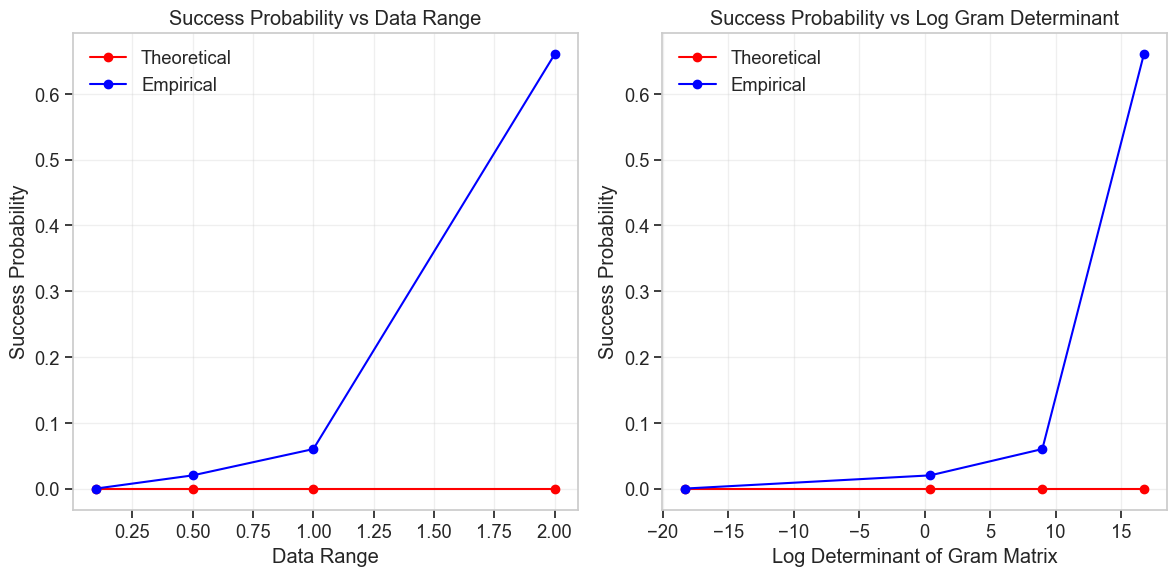

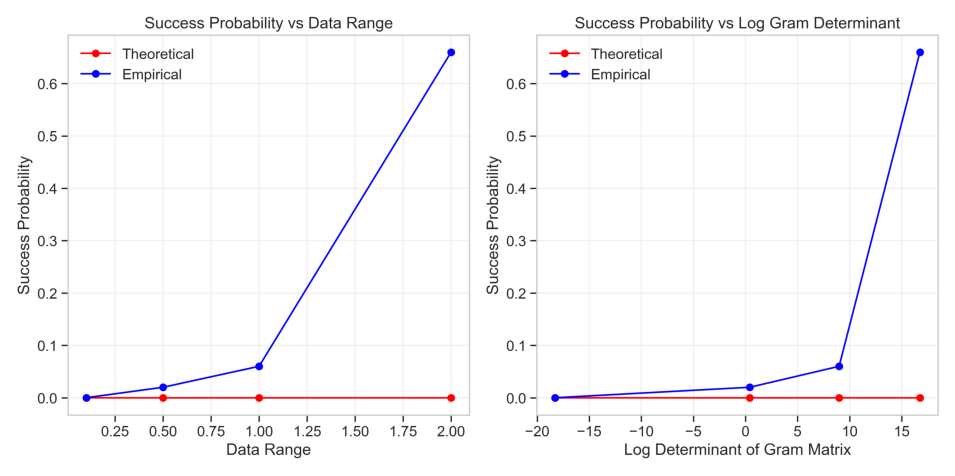

In [19]:
# Analyze data range effect
range_analysis = analysis.analyze_data_range_effect(n_samples=150, x_ranges=[0.1, 0.5, 1.0, 2.0])

# Display the results
print("Data Range Effect Analysis:")
display(range_analysis['dataframe'])

# Show the figure
plt.figure(figsize=(12, 5))
img = plt.imread(range_analysis['figure_path'])
plt.imshow(img)
plt.axis('off')
plt.tight_layout()

INFO - Analyzing effect of sample size: [50, 100, 200, 300]
INFO - Testing sample size: 50
INFO - Preparing data with range 1.0 and 50 samples
INFO - Computing Gram matrix with 50 sample points
INFO - Log determinant of Gram matrix: 4.2647
INFO - Discriminability between true and false terms:
INFO -   D(0,2) = 15.9647
INFO -   D(0,3) = 4925.1670
INFO -   D(1,2) = 1943.5318
INFO -   D(1,3) = 2204.7579
INFO - High correlation detected: terms 0 and 2: 0.9991
INFO - High correlation detected: terms 1 and 3: -0.9998
INFO - BEGINNING SUCCESS PROBABILITY CALCULATION
INFO - All indices = {0, 1, 2, 3}
INFO - True indices = {0, 1}
INFO - Target state (true model) = {0, 1}
INFO - Generated 4 valid states
INFO - TRUE MODEL STATE TRANSITIONS
INFO - Transitions from {0, 1}:
    -> [STOP]: 1.000000
INFO - TRUE MODEL STATE STOPPING PROBABILITY: 1.000000

INFO - SUCCESS PROBABILITY CALCULATION
INFO - Method 1 - Direct Calculation:
INFO -   Probability of reaching true state:    0.000000
INFO -   Probab

Sample Size Effect Analysis:


,n_samples,log_gram_det,avg_discriminability,theoretical_prob,empirical_prob,discrepancy
0,50,4.264706,2658.599871,0.0,0.06,0.06
1,100,7.004377,5686.766904,0.0,0.06,0.06
2,200,10.145330,12110.476177,0.0,0.10,0.10
3,300,11.596374,16392.877369,0.0,0.08,0.08


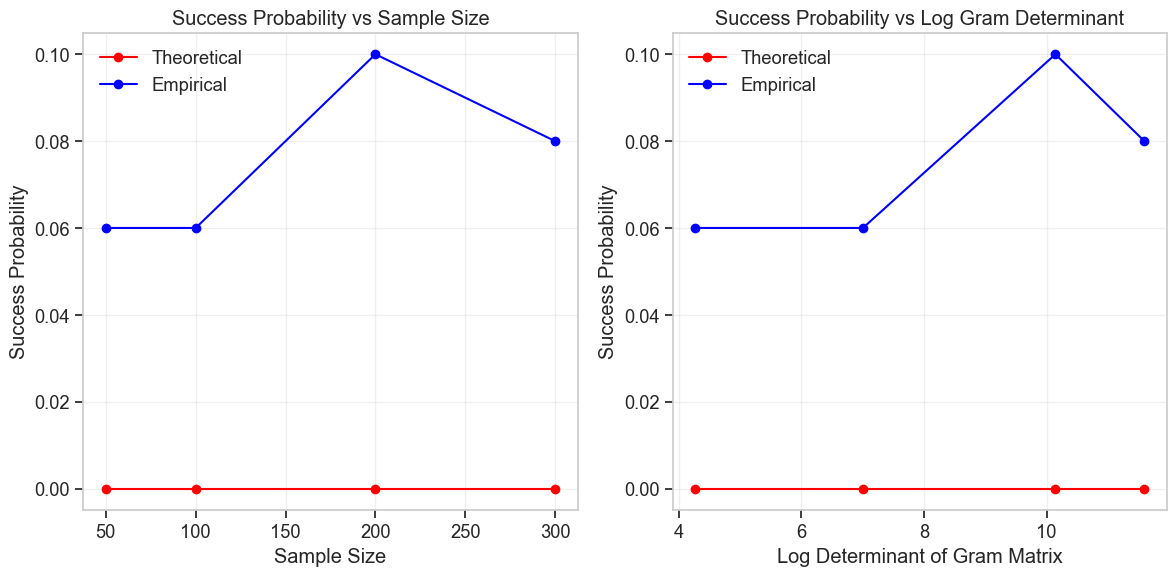

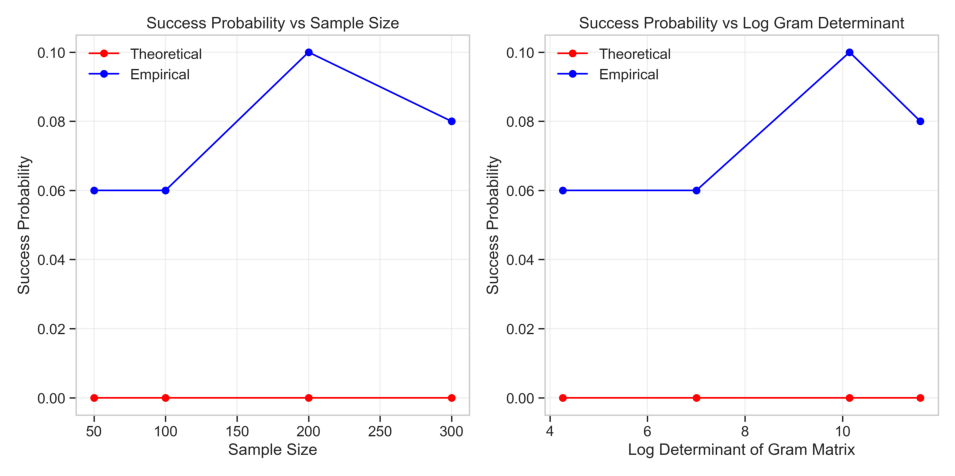

In [20]:
# Analyze sample size effect
sample_analysis = analysis.analyze_sample_size_effect(x_range=1.0, n_samples_list=[50, 100, 200, 300])

# Display the results
print("Sample Size Effect Analysis:")
display(sample_analysis['dataframe'])

# Show the figure
plt.figure(figsize=(12, 5))
img = plt.imread(sample_analysis['figure_path'])
plt.imshow(img)
plt.axis('off')
plt.tight_layout()

INFO - Analyzing effect of lambda/sigma ratio: [0.1, 0.2, 0.5, 1.0, 2.0, 5.0]
INFO - Testing lambda/sigma ratio: 0.1
INFO - Initializing SINDy Markov Model
INFO - True term indices: [0 1]
INFO - Computing Gram matrix with 200 sample points
INFO - Log determinant of Gram matrix: 9.9105
INFO - BEGINNING SUCCESS PROBABILITY CALCULATION
INFO - All indices = {0, 1, 2, 3}
INFO - True indices = {0, 1}
INFO - Target state (true model) = {0, 1}
INFO - Generated 4 valid states
INFO - TRUE MODEL STATE TRANSITIONS
INFO - Transitions from {0, 1}:
    -> [STOP]: 1.000000
INFO - TRUE MODEL STATE STOPPING PROBABILITY: 1.000000

ERROR - Error calculating transition probability: unhashable type: 'numpy.ndarray'
ERROR - Error calculating transition probability: unhashable type: 'numpy.ndarray'
ERROR - Error calculating transition probability: unhashable type: 'numpy.ndarray'
ERROR - Error calculating transition probability: unhashable type: 'numpy.ndarray'
ERROR - Error calculating transition probability

Lambda/Sigma Ratio Effect Analysis:


,lambda_sigma_ratio,threshold,log_gram_det,theoretical_prob,empirical_prob,discrepancy
0,0.1,0.01,9.910451,0.0,0.000000,0.000000
1,0.2,0.02,9.910451,0.0,0.100000,0.100000
2,0.5,0.05,9.910451,0.0,0.100000,0.100000
3,1.0,0.10,9.910451,0.0,0.233333,0.233333
4,2.0,0.20,9.910451,0.0,0.333333,0.333333
5,5.0,0.50,9.910451,0.0,0.166667,0.166667


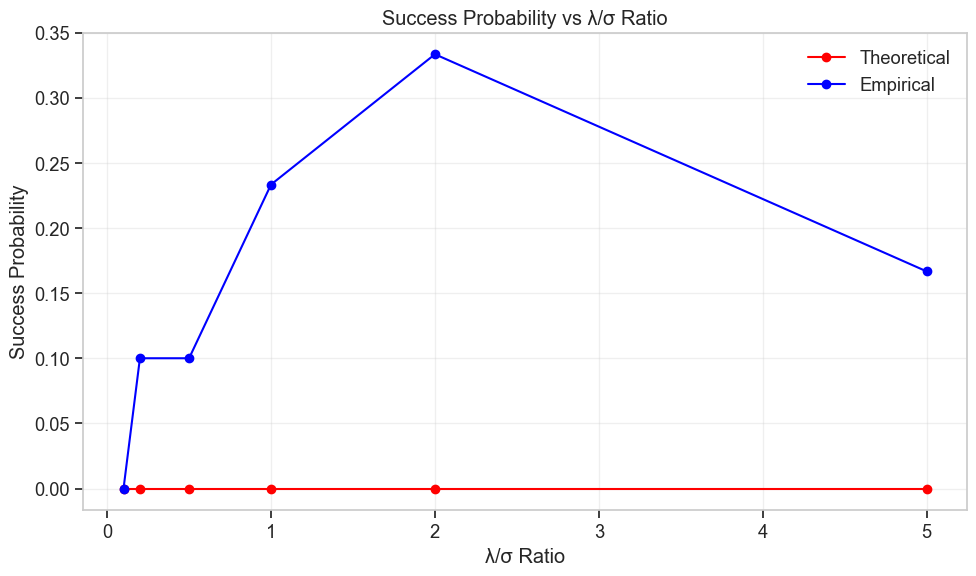

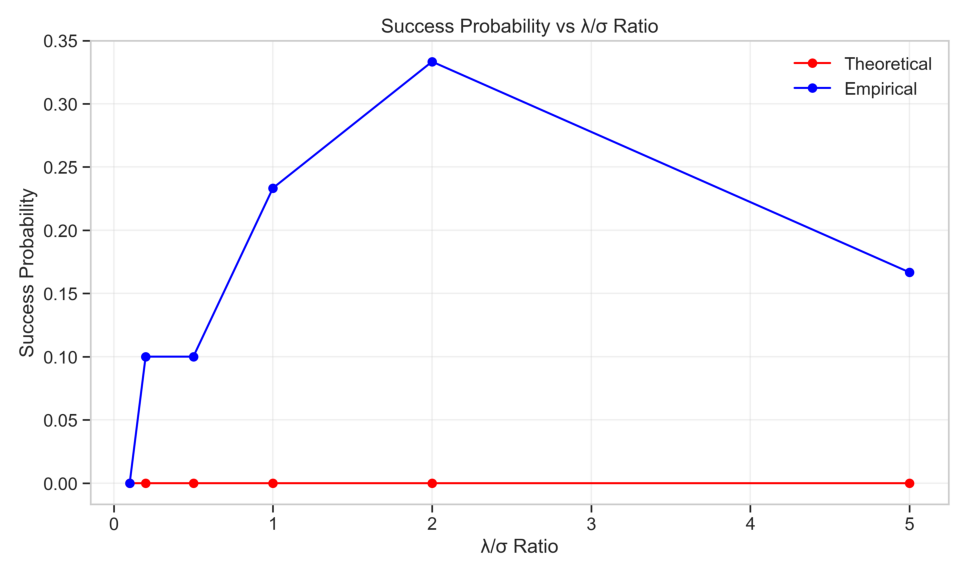

In [21]:
# Analyze lambda/sigma effect
lambda_analysis = analysis.analyze_lambda_sigma_effect(n_trials=30)

# Display the results
print("Lambda/Sigma Ratio Effect Analysis:")
display(lambda_analysis['dataframe'])

# Show the figure
plt.figure(figsize=(10, 6))
img = plt.imread(lambda_analysis['figure_path'])
plt.imshow(img)
plt.axis('off')
plt.tight_layout()

In [22]:
# Save all results
result_file = analysis.save_results()
print(f"All results saved to {result_file}")

# Create markdown log
log_md = os.path.splitext(log_file)[0] + '.md'
log_to_markdown(log_file, log_md)
print(f"Markdown log created at {log_md}")

INFO - Results saved to results/sindy_markov_analysis_results.json


Markdown log created: logs/notebook_comprehensive.md
All results saved to results/sindy_markov_analysis_results.json
Markdown log created: logs/notebook_comprehensive.md
Markdown log created at logs/notebook_comprehensive.md


## Part 3: Adaptive Trial Count Approach

Lastly, we'll demonstrate the adaptive trial count approach, which automatically determines how many trials are needed to achieve a desired level of confidence.

In [23]:
# Set up logging
log_file = 'logs/notebook_adaptive.log'
logger = setup_logging(log_file)
logger.info("Starting adaptive simulation test in notebook")

# Create a simple model again
def f1(x): return x           # Term 1: x
def f2(x): return np.sin(x)   # Term 2: sin(x)
def f3(x): return np.tanh(x)  # Term 3: tanh(x)

library_functions = [f1, f2, f3]
true_coefs = np.array([1.0, 0.0, 0.0])

sigma = 0.1
threshold = 0.05
model = SINDyMarkovModel(library_functions, true_coefs, sigma, threshold, log_file)

INFO - Starting adaptive simulation test in notebook
INFO - Initializing SINDy Markov Model
INFO - True term indices: [0]


In [24]:
# Generate sample points
x_range = 1.0
n_samples = 200
x_data = np.random.uniform(-x_range, x_range, n_samples)

# Compute Gram matrix
model.compute_gram_matrix(x_data)

# Calculate theoretical success probability
theoretical_prob = model.calculate_success_probability()
print(f"Theoretical success probability: {theoretical_prob:.6f}")

INFO - Computing Gram matrix with 200 sample points
INFO - Log determinant of Gram matrix: -5.0778
INFO - BEGINNING SUCCESS PROBABILITY CALCULATION
INFO - All indices = {0, 1, 2}
INFO - True indices = {0}
INFO - Target state (true model) = {0}
INFO - Generated 4 valid states
INFO - TRUE MODEL STATE TRANSITIONS
INFO - Transitions from {0}:
    -> [STOP]: 1.000000
INFO - TRUE MODEL STATE STOPPING PROBABILITY: 1.000000

ERROR - Error calculating transition probability: unhashable type: 'numpy.ndarray'
ERROR - Error calculating transition probability: unhashable type: 'numpy.ndarray'
ERROR - Error calculating transition probability: unhashable type: 'numpy.ndarray'
ERROR - Error calculating transition probability: unhashable type: 'numpy.ndarray'
ERROR - Error calculating transition probability: unhashable type: 'numpy.ndarray'
INFO - SUCCESS PROBABILITY CALCULATION
INFO - Method 1 - Direct Calculation:
INFO -   Probability of reaching true state:    0.000000
INFO -   Probability of stoppi

Theoretical success probability: 0.000000


In [25]:
# Run adaptive trial simulation
start_time = time.time()
empirical_prob, trials_used, details = simulate_stlsq_adaptive(
    model, 
    x_data, 
    max_trials=500,
    confidence=0.95,
    margin=0.03,
    min_trials=30,
    return_details=True
)
adaptive_time = time.time() - start_time

print(f"Adaptive simulation results:")
print(f"  Empirical success probability: {empirical_prob:.6f}")
print(f"  Trials used: {trials_used}")
print(f"  Margin of error: {details['margin']:.6f}")
print(f"  Simulation time: {adaptive_time:.2f} seconds")

# Calculate discrepancy
discrepancy = abs(theoretical_prob - empirical_prob)
print(f"Discrepancy: {discrepancy:.6f}")

INFO - Running adaptive STLSQ simulation (max 500 trials, 95% confidence, 3.0% margin)
INFO - After 30 trials: Success rate = 0.0000, Margin of error = ±0.2198 (target: 0.0300)
INFO - After 50 trials: Success rate = 0.0200, Margin of error = ±0.1820 (target: 0.0300)
INFO - After 100 trials: Success rate = 0.0100, Margin of error = ±0.1321 (target: 0.0300)
INFO - After 150 trials: Success rate = 0.0067, Margin of error = ±0.1089 (target: 0.0300)
INFO - After 200 trials: Success rate = 0.0050, Margin of error = ±0.0947 (target: 0.0300)
INFO - After 250 trials: Success rate = 0.0080, Margin of error = ±0.0853 (target: 0.0300)
INFO - After 300 trials: Success rate = 0.0067, Margin of error = ±0.0780 (target: 0.0300)
INFO - After 350 trials: Success rate = 0.0057, Margin of error = ±0.0722 (target: 0.0300)
INFO - After 400 trials: Success rate = 0.0050, Margin of error = ±0.0676 (target: 0.0300)
INFO - After 450 trials: Success rate = 0.0044, Margin of error = ±0.0638 (target: 0.0300)
INFO 

Adaptive simulation results:
  Empirical success probability: 0.004000
  Trials used: 500
  Margin of error: 0.060525
  Simulation time: 0.10 seconds
Discrepancy: 0.004000


In [26]:
# Analyze trajectory distribution
trajectory_counts = details['trajectory_counts']
top_trajectories = sorted(trajectory_counts.items(), key=lambda x: x[1], reverse=True)[:5]

print("Top 5 most common trajectories:")
for i, (traj, count) in enumerate(top_trajectories):
    print(f"{i+1}. {traj}: {count} occurrences ({count/trials_used*100:.1f}%)")

Top 5 most common trajectories:
1. [0, 1, 2] -> [STOP]: 473 occurrences (94.6%)
2. [1, 2] -> [STOP]: 15 occurrences (3.0%)
3. [0, 1] -> [STOP]: 7 occurrences (1.4%)
4. [0, 2] -> [STOP]: 3 occurrences (0.6%)
5. [0, 1] -> [0] -> [STOP]: 1 occurrences (0.2%)


In [27]:
# Create a markdown version of the log
log_md = os.path.splitext(log_file)[0] + '.md'
log_to_markdown(log_file, log_md)
print(f"Markdown log created at {log_md}")

Markdown log created: logs/notebook_adaptive.md
Markdown log created at logs/notebook_adaptive.md


## Conclusion

This notebook has demonstrated the improved SINDy Markov Chain Model and its analysis capabilities. The model provides accurate predictions of success probabilities for the STLSQ algorithm and offers valuable insights into the factors that affect these probabilities.